In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm

# Local Level Model

The Local Level model is one of the simplest state space models. It assumes that the observed time series data ($y_t$) is driven by an underlying unobserved state ($\mu_t$) plus some noise. 

The model consists of two main equations:

- Observation Equation

$$
y_{t} = \mu_t + \nu_t
$$

- $y_t$ represents the observed value at time $t$.
- $\mu_t$ is the underlying unobserved state at time $t$.
- $\nu_t$ is the observation noise at time $t$, typically assumed to be white noise with mean zero and variance $\sigma_{\nu}^2$.
  
Thus, the observed value at any given time is the sum of the state $\mu_t$ and some random noise $\nu_t$.

- State Equation

$$
\mu_{t} = \mu_{t-1} + \eta_t
$$

- $\mu_t$ is the state at time $t$, and it is assumed to follow a random walk process.
- $\mu_{t-1}$ is the state at the previous time step.
- $\eta_t$ is the state noise at time $t$, assumed to be white noise with mean zero and variance $\sigma_{\eta}^2$.

This equation models the evolution of the underlying state $\mu_t$, assuming it changes slowly over time, with random fluctuations due to $\eta_t$.


## Data Generation

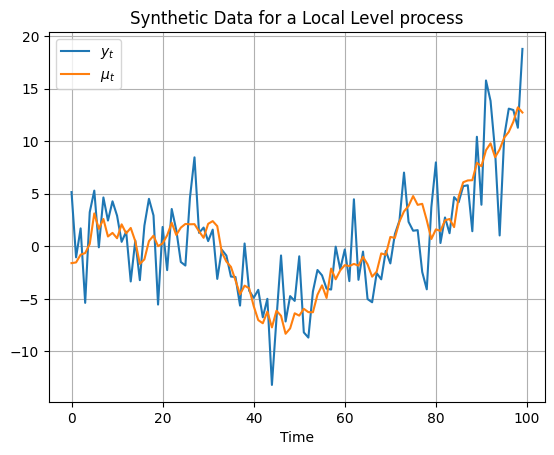

In [2]:
from numpy.random import default_rng

rng = default_rng(1234)
true_var_eta = 9
true_var_nu = 1

mu = np.cumsum(rng.standard_normal(size=(100,1))*np.sqrt(true_var_nu**2), axis=0)
y = mu + rng.standard_normal(size=(100,1)) * np.sqrt(true_var_eta)

plt.title("Synthetic Data for a Local Level process")
plt.plot(y, label="$y_t$")
plt.plot(mu, label="$\\mu_t$")
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

## `PyMCStateSpace` model

In [3]:
from pymc_extras.statespace.models.utilities import make_default_coords

class LocalLevel(PyMCStateSpace):
    def __init__(self):
        super().__init__(k_endog=1, k_states=1, k_posdef=1)

        # Declare the non-zero, non-parameterized matrices
        self.ssm['transition', 0, 0] = 1
        self.ssm['selection', 0, 0] = 1
        self.ssm['design', 0, 0] = 1

    @property
    def param_names(self):
        return ['x0', 'P0', 'var_nu', 'var_eta']

    @property
    def state_names(self):
        return ["x"]

    @property
    def shock_names(self):
        return ["innovations"]

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable('x0', shape=())
        P0 = self.make_and_register_variable('P0', shape=())
        var_nu = self.make_and_register_variable('var_nu', shape=())
        var_eta = self.make_and_register_variable('var_eta', shape=())

        self.ssm['initial_state', 0] = x0
        self.ssm['initial_state_cov', 0] = P0
        
        self.ssm['state_cov', 0, 0] = var_nu
        self.ssm['obs_cov', 0, 0] = var_eta

    @property
    def coords(self):
        coords = make_default_coords(self)
        return coords
    
    @property
    def observed_states(self):
        return ["data"]

### Model

In [4]:
ll = LocalLevel()

with pm.Model(coords=ll.coords) as ll_mod:
    # Can't use to sample conditional posterior. Reasone: cannot sample a FlatRV .
    # x0 = pm.Data("x0", 0) 
    # P0 = pm.Data("P0", 1)

    x0 = pm.Normal('x0', shape=())
    P0 = pm.Exponential('P0', 1, shape=())

    var_nu = pm.Exponential("var_nu", lam=0.01)
    var_eta = pm.Exponential("var_eta", lam=0.01)

    ll.build_statespace_graph(data=y)

{'state': ('x',), 'state_aux': ('x',), 'observed_state': ('data',), 'observed_state_aux': ('data',), 'shock': ('innovations',), 'shock_aux': ('innovations',), 'time': (np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np

/home/victor/Work/Projects/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


### Prior Predictive check

/home/victor/Work/Projects/pymc-extras/venv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7FA0CAA46500>), RNG(<Generator(PCG64) at 0x7FA0CAAB74C0>), RNG(<Generator(PCG64) at 0x7FA0CAA475A0>), RNG(<Generator(PCG64) at 0x7FA0CAAB73E0>), RNG(<Generator(PCG64) at 0x7FA0CAA47760>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [P0, obs, var_eta, var_nu, x0]


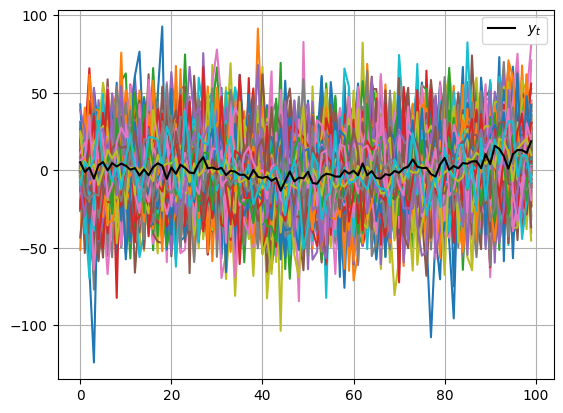

In [5]:
with ll_mod:
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"}, random_seed=rng)

plt.plot(prior.prior_predictive.obs[0,...,0].T)
plt.plot(y, color="black", label="$y_t$")
plt.legend()
plt.grid()
plt.show()

### Computing posterior distributions

In [6]:
with ll_mod:
    idata = pm.sample(
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.88,7
,2000,0,0.81,7
,2000,0,0.84,3
,2000,0,0.80,3


Before analyzing the results, let's run a couple of sanity checks to evaluate te convergence of the MCMC algorithm.

Firstly, let's check the traces:

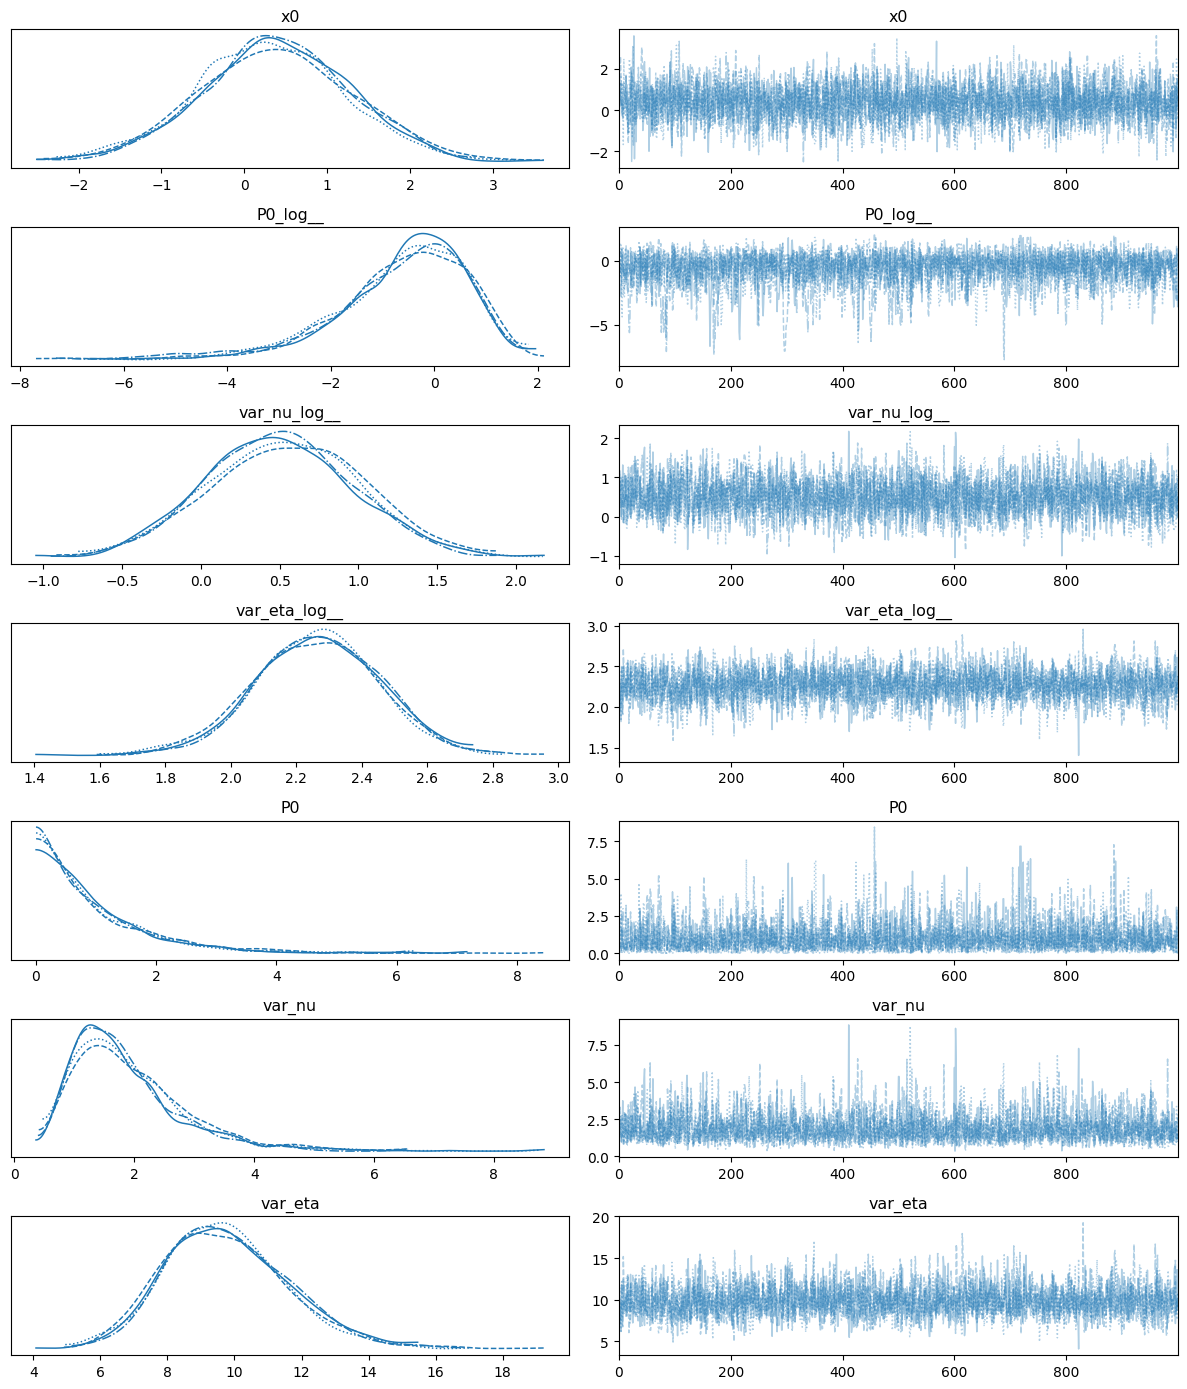

In [7]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

Secondly, let's check the autocorrelation of the 4 chains for the two parameters:

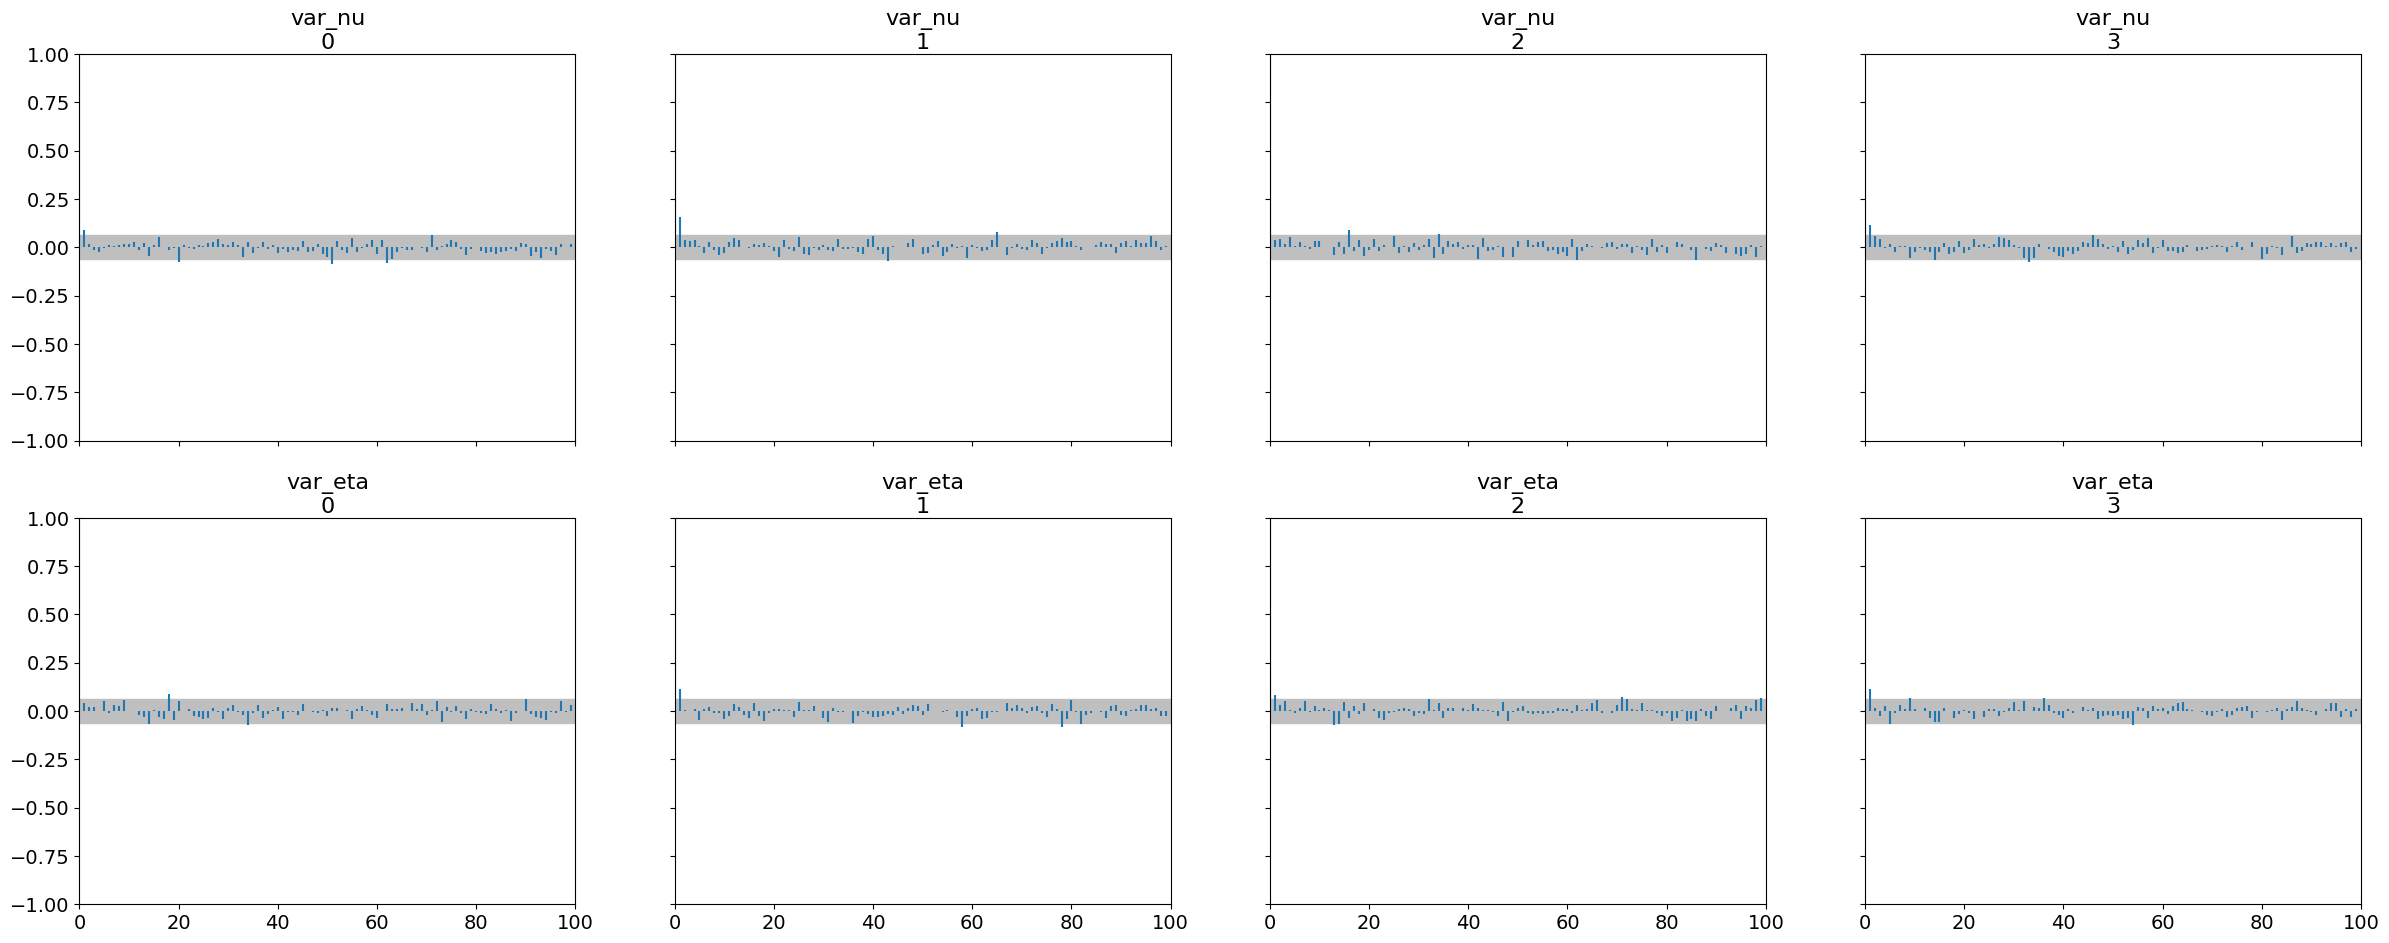

In [8]:
az.plot_autocorr(idata, var_names=["var_nu", "var_eta"])
plt.show()

Now, let's plot the posterior distributions:

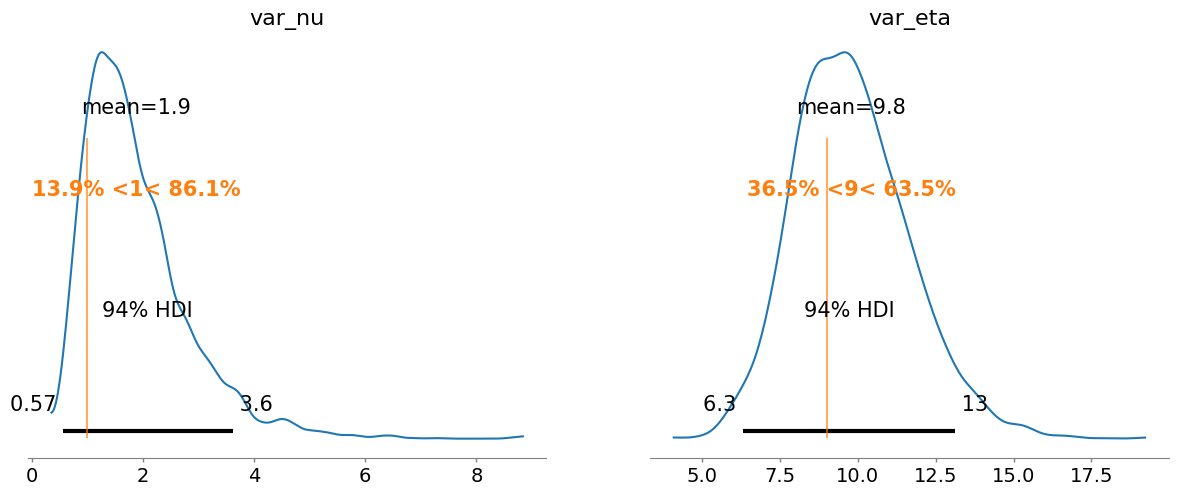

In [9]:
az.plot_posterior(
    idata, var_names=["var_nu", "var_eta"],  ref_val=[true_var_nu, true_var_eta]
)
plt.show()

In [10]:
post = ll.sample_conditional_posterior(idata)

/home/victor/Work/Projects/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

### Smoothed posterior

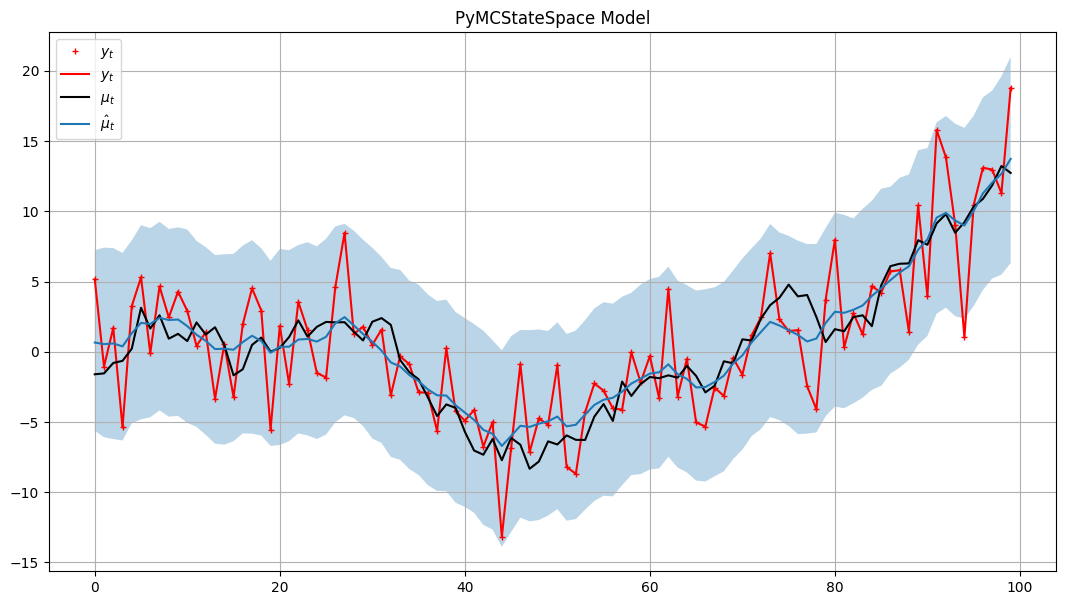

In [20]:
smoothed_posterior = post["smoothed_posterior_observed"]


smoothed_posterior = post["smoothed_posterior_observed"].values.reshape(-1, 100)
smoothed_mean = smoothed_posterior.mean(0)

smoothed_q025 = np.quantile(smoothed_posterior, 0.025, axis=0)
smoothed_q975 = np.quantile(smoothed_posterior, 0.975, axis=0)

plt.figure(figsize=(13,7))
plt.title("PyMCStateSpace Model")
plt.fill_between(
    np.arange(len(smoothed_mean)),
    smoothed_q025,
    smoothed_q975,
    alpha=0.3
)

plt.plot(y, color="red", marker="+", ls="",markersize=5, label="$y_t$")
plt.plot(y, color="red",markersize=5, label="$y_t$")
plt.plot(mu, color="black", label="$\\mu_t$")
plt.plot(smoothed_mean, label="$\\hat{\\mu}_t$")
plt.grid()
plt.legend()
plt.show()

## StatsModels State Space model

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                   LocalLevelSM   Log Likelihood                -271.149
Date:                Fri, 04 Apr 2025   AIC                            546.298
Time:                        12:25:11   BIC                            551.488
Sample:                             0   HQIC                           548.398
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
obs.var        9.5754      1.900      5.039      0.000       5.851      13.300
level.var      1.3566      0.711      1.908      0.056      -0.037       2.750
Ljung-Box (L1) (Q):                   0.01   Jarque-

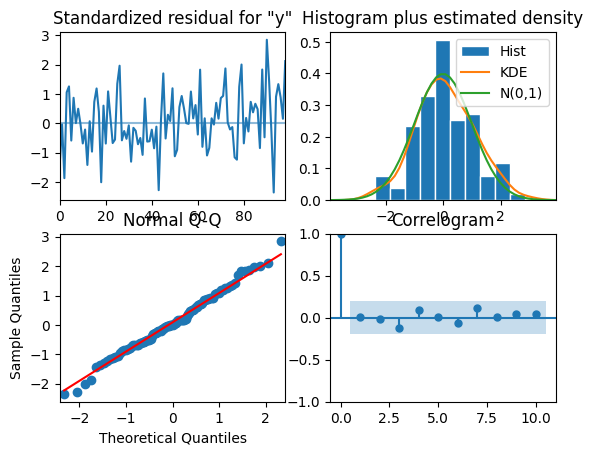

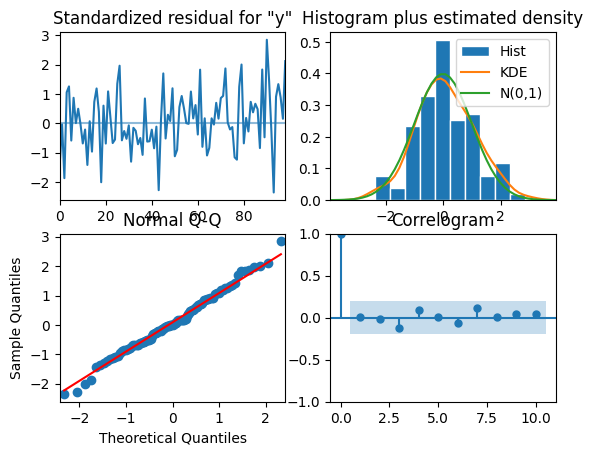

In [31]:
import statsmodels.api as sm

class LocalLevelSM(sm.tsa.statespace.MLEModel):
    start_params = [1, 1]
    param_names = ['obs.var', 'level.var']

    def __init__(self, endog):
        super(LocalLevelSM, self).__init__(endog, k_states=1)

        self['design', 0, 0] = 1.0
        self['transition', 0, 0] = 1.0
        self['selection', 0, 0] = 1.0

        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 1

    def transform_params(self, params):
        return params**2

    def untransform_params(self, params):
        return params**0.5

    def update(self, params, **kwargs):
        params = super(LocalLevelSM, self).update(params, **kwargs)

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]

model_SM = LocalLevelSM(y)
sm_result = model_SM.fit()
print(sm_result.summary())

sm_result.plot_diagnostics()


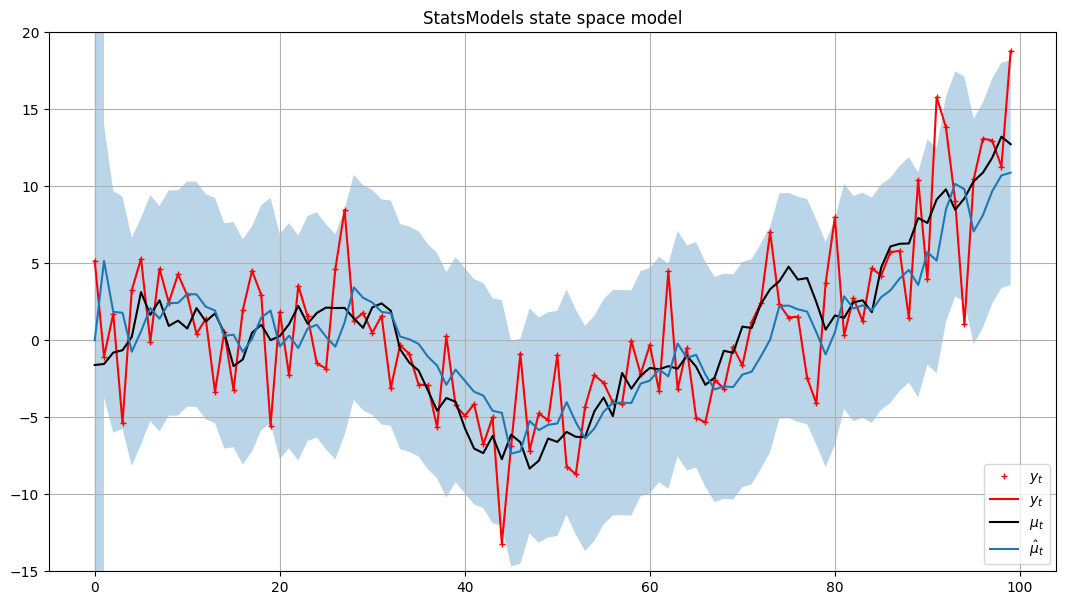

In [43]:
import scipy
plt.figure(figsize=(13,7))
plt.title("StatsModels state space model")

sm_predict = sm_result.get_prediction()

q0025 = scipy.stats.norm.ppf(0.025)

plt.fill_between(
    np.arange(len(smoothed_mean)),
    sm_predict.predicted_mean + np.sqrt(sm_predict.var_pred_mean)*q0025,
    sm_predict.predicted_mean - np.sqrt(sm_predict.var_pred_mean)*q0025,
    alpha=0.3
)

plt.plot(y, color="red", marker="+", ls="",markersize=5, label="$y_t$")
plt.plot(y, color="red",markersize=5, label="$y_t$")
plt.plot(mu, color="black", label="$\\mu_t$")
plt.plot(sm_predict.predicted_mean, label="$\\hat{\\mu}_t$")
plt.grid()
plt.legend()
plt.ylim([-15,20])
plt.show()


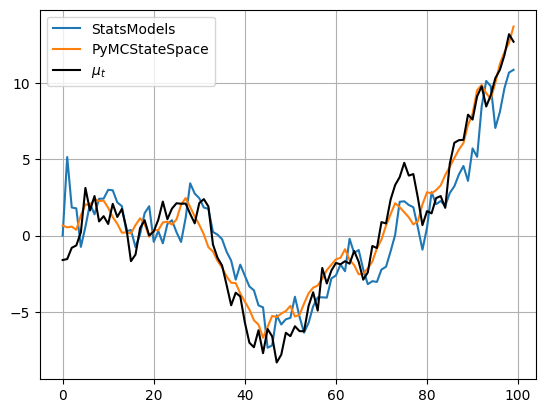

In [47]:
plt.plot(sm_predict.predicted_mean, label="StatsModels")
plt.plot(smoothed_mean, label="PyMCStateSpace")
plt.plot(mu, color="black", label="$\\mu_t$")
plt.legend()
plt.grid()
plt.show()